<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#Some-general-parameters" data-toc-modified-id="Some-general-parameters-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Some general parameters</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Functions</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Create-overlap" data-toc-modified-id="Create-overlap-1.2.0.1"><span class="toc-item-num">1.2.0.1&nbsp;&nbsp;</span>Create overlap</a></span></li><li><span><a href="#Activity-representation" data-toc-modified-id="Activity-representation-1.2.0.2"><span class="toc-item-num">1.2.0.2&nbsp;&nbsp;</span>Activity representation</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#The-example" data-toc-modified-id="The-example-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>The example</a></span></li></ul></div>

# Preamble

In [1]:
import  pprint
import  subprocess 
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline

np.set_printoptions(suppress=True, precision=5)

from network import Protocol, NetworkManager, Network
from patterns_representation import PatternsRepresentation
from analysis_functions import calculate_persistence_time, calculate_recall_quantities, calculate_triad_connectivity
from plotting_functions import plot_weight_matrix, plot_network_activity_angle, plot_persistent_matrix

## Some general parameters

In [2]:
epsilon = 10e-80
vmin = -3.0
remove = 0.010

strict_maximum = True

dt = 0.001
tau_s = 0.010
tau_a = 0.250
g_I = 2.0
g_a = 2.0
G = 50.0

sns.set(font_scale=3.5)
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['figure.figsize'] = (12, 8)
lw = 10
ms = 22
alpha_graph = 0.3
colors = sns.color_palette()

## Functions

#### Create overlap

In [3]:
from copy import deepcopy

def create_overalaped_representation(manager, representation_overlap, sequence_overlap):
    x = deepcopy(manager.canonical_activity_representation)

    to_modify = int(representation_overlap * len(x[0]))
    sequence_size = int(0.5 * len(x))
    sequence_overlap_size = int(sequence_overlap * sequence_size)
    start_point = int(0.5 * sequence_size + sequence_size - np.floor(sequence_overlap_size/ 2.0))
    end_point = start_point + sequence_overlap_size

    for sequence_index in range(start_point, end_point):
        pattern = x[sequence_index]
        pattern[:to_modify] = manager.canonical_activity_representation[sequence_index - sequence_size][:to_modify]

    return x

#### Activity representation

In [4]:
activity_representation = np.array([[0, 0, 0], [1, 1, 1], [2, 2, 2], [3, 3, 3], [4, 4, 4], [5, 5, 5], 
     [10, 10, 10], [11, 11, 11], [2, 2, 12], [3, 3, 13], [14, 14, 14], [15, 15, 15]])

# The example

In [5]:
sigma_out = 0.0
tau_z_pre = 0.025
tau_z_post = 0.020

hypercolumns = 3
minicolumns = 20
n_patterns = 12
patterns_per_sequence = 6
representation_overlap = 0.75
sequence_overlap = 0.5

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.0
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 1.0
resting_time = 1.0
epochs = 1
T_persistence = 1.0 / patterns_per_sequence

# Manager properties
values_to_save = ['o']


# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the representation
representation = PatternsRepresentation(activity_representation, minicolumns=minicolumns)
inter_pulse_intervals[patterns_per_sequence - 1] = inter_sequence_interval


# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)
# Set the persistent time
manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence, from_state=1, to_state=2)

../connectivity_functions.py:15: RuntimeWarning: invalid value encountered in true_divide
  x = P / outer


1.6600112905646132

In [6]:
patterns_per_sequence = 6
T_cue = 2.0 * manager.nn.tau_s
T_recall = T_persistence * 6 + T_cue

nr1 = representation.network_representation[:patterns_per_sequence]
nr2 = representation.network_representation[patterns_per_sequence:]

# Success 1
aux1 = calculate_recall_quantities(manager, nr1, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
success1, pattern_sequence1, persistent_times1, timings1 = aux1

# Success 2
aux2 = calculate_recall_quantities(manager, nr2, T_recall, T_cue, remove=remove, reset=False, empty_history=False)
success2, pattern_sequence2, persistent_times2, timings2 = aux2

total_success = 0.5 * success1 + 0.5 * success2

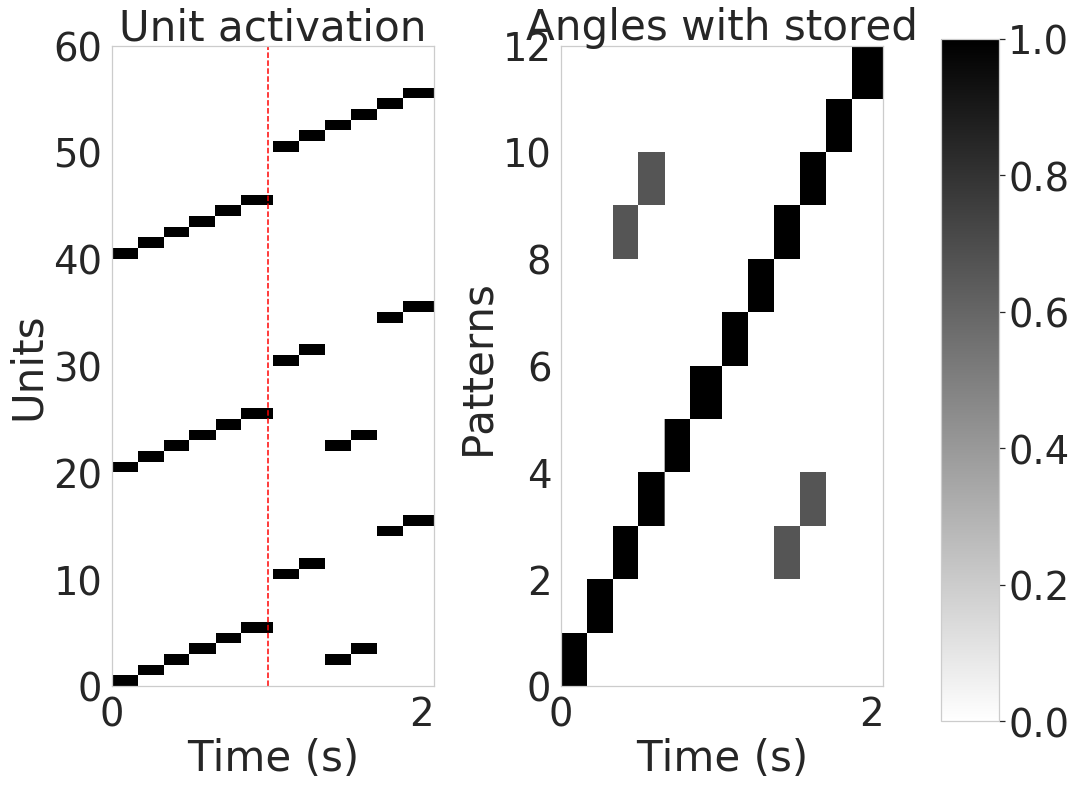

In [7]:
cmap = matplotlib.cm.binary
ax1, ax2 = plot_network_activity_angle(manager, cmap=cmap, time_y=False)
ax1.axvline(T_recall - tau_s, ls='--', color='red')

In [8]:
nr1 = representation.network_representation[:patterns_per_sequence]
nr2 = representation.network_representation[patterns_per_sequence:]

# Success 1
aux1 = calculate_recall_quantities(manager, nr1, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
success1, pattern_sequence1, persistent_times1, timings1 = aux1
o1 = manager.history['o']

# Success 2
aux2 = calculate_recall_quantities(manager, nr2, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
success2, pattern_sequence2, persistent_times2, timings2 = aux2
o2 = manager.history['o']

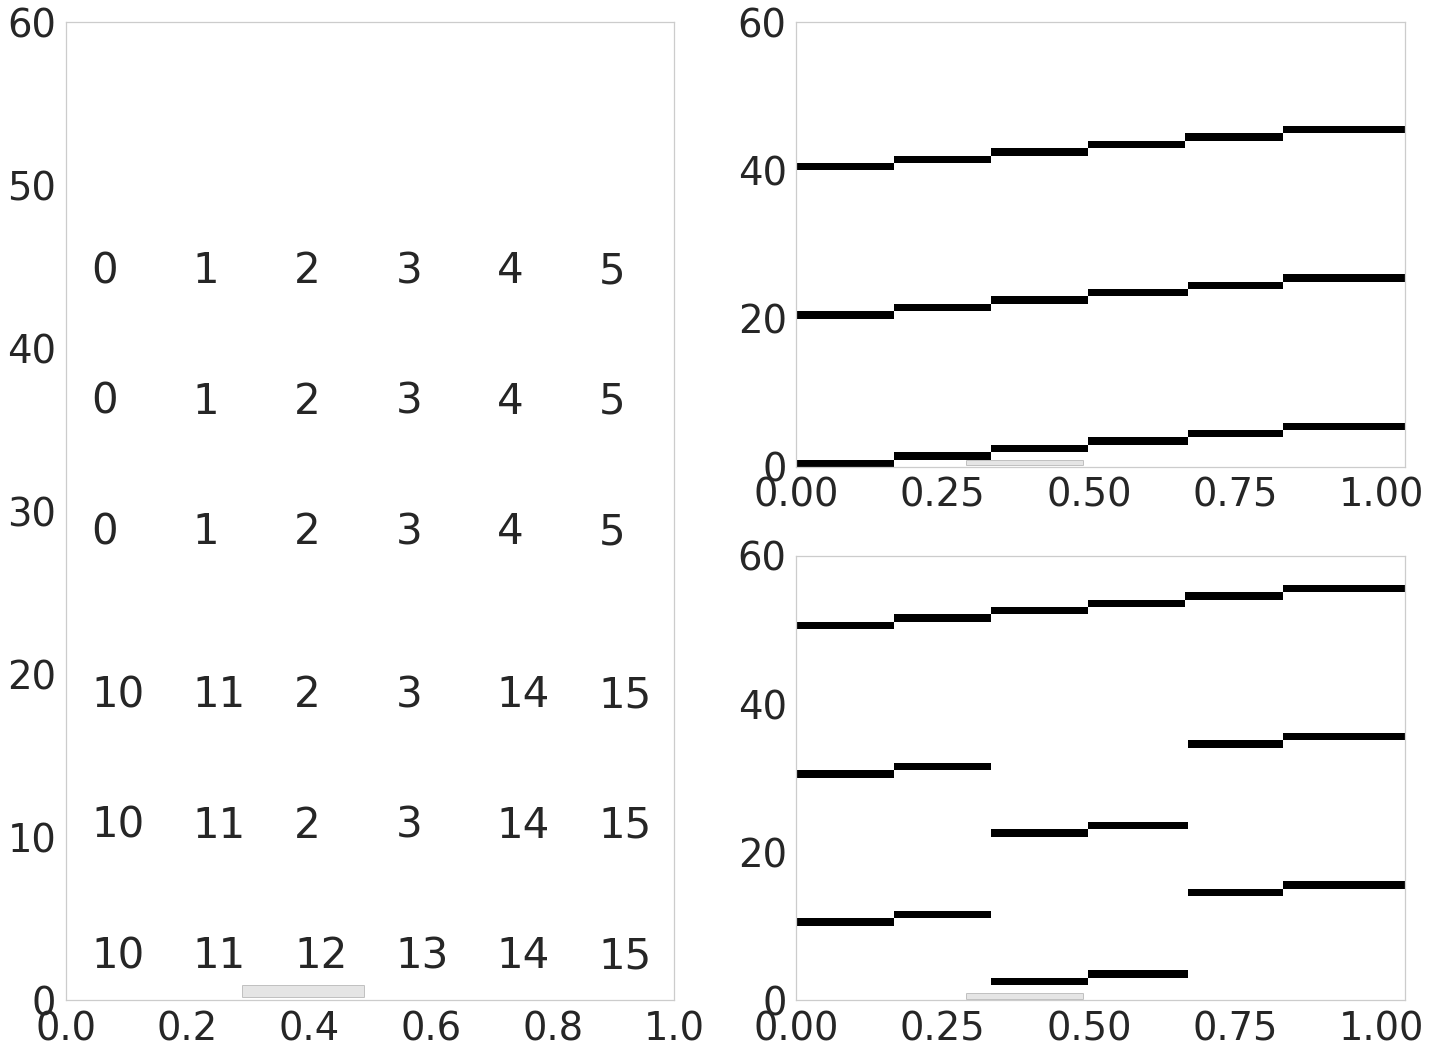

In [9]:
rect = plt.Rectangle((0.29, 0.2), 0.2, 0.72, linewidth=1, edgecolor='black',facecolor='gray', alpha=0.2)
rect2 = plt.Rectangle((0.29, 0.2), 0.2, 0.72, linewidth=1, edgecolor='black',facecolor='gray', alpha=0.2)
rect3 = plt.Rectangle((0.29, 0.2), 0.2, 0.72, linewidth=1, edgecolor='black',facecolor='gray', alpha=0.2)


factor_scale = 1.5
s1 = int(16 * factor_scale)
s2 = int(12 * factor_scale)

gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(s1, s2))
ax = fig.add_subplot(gs[:, 0])
ax.set_ylim([0, minicolumns * hypercolumns])

start = T_persistence * 0.25
dx = T_persistence
dy = minicolumns * 0.4
y1 = 28
y2 = 2

sequence1 = activity_representation[:patterns_per_sequence]
sequence2 = activity_representation[patterns_per_sequence:]

x = start
for pattern in sequence1:
    for index, unit in enumerate(pattern): 
        ax.text(x, y1 + index*dy, str(pattern[index]))
    x += dx

x = start 
for pattern in sequence2:
    for index, unit in enumerate(pattern): 
        ax.text(x, y2 + index*dy, str(pattern[hypercolumns - 1- index]))
    x += dx

ax.add_patch(rect)
#ax.axis('off')

ax2 = fig.add_subplot(gs[0, 1])


cmap = matplotlib.cm.binary
extent = [0, manager.T_recall_total, 0, minicolumns * hypercolumns]
ax2.imshow(o1.T, origin='lower', cmap=cmap, aspect='auto', extent=extent)

ax2.add_patch(rect2)


ax3 = fig.add_subplot(gs[1, 1])

cmap = matplotlib.cm.binary
extent = [0, manager.T_recall_total, 0, minicolumns * hypercolumns]
ax3.imshow(o2.T, origin='lower', cmap=cmap, aspect='auto', extent=extent)

ax3.add_patch(rect3)


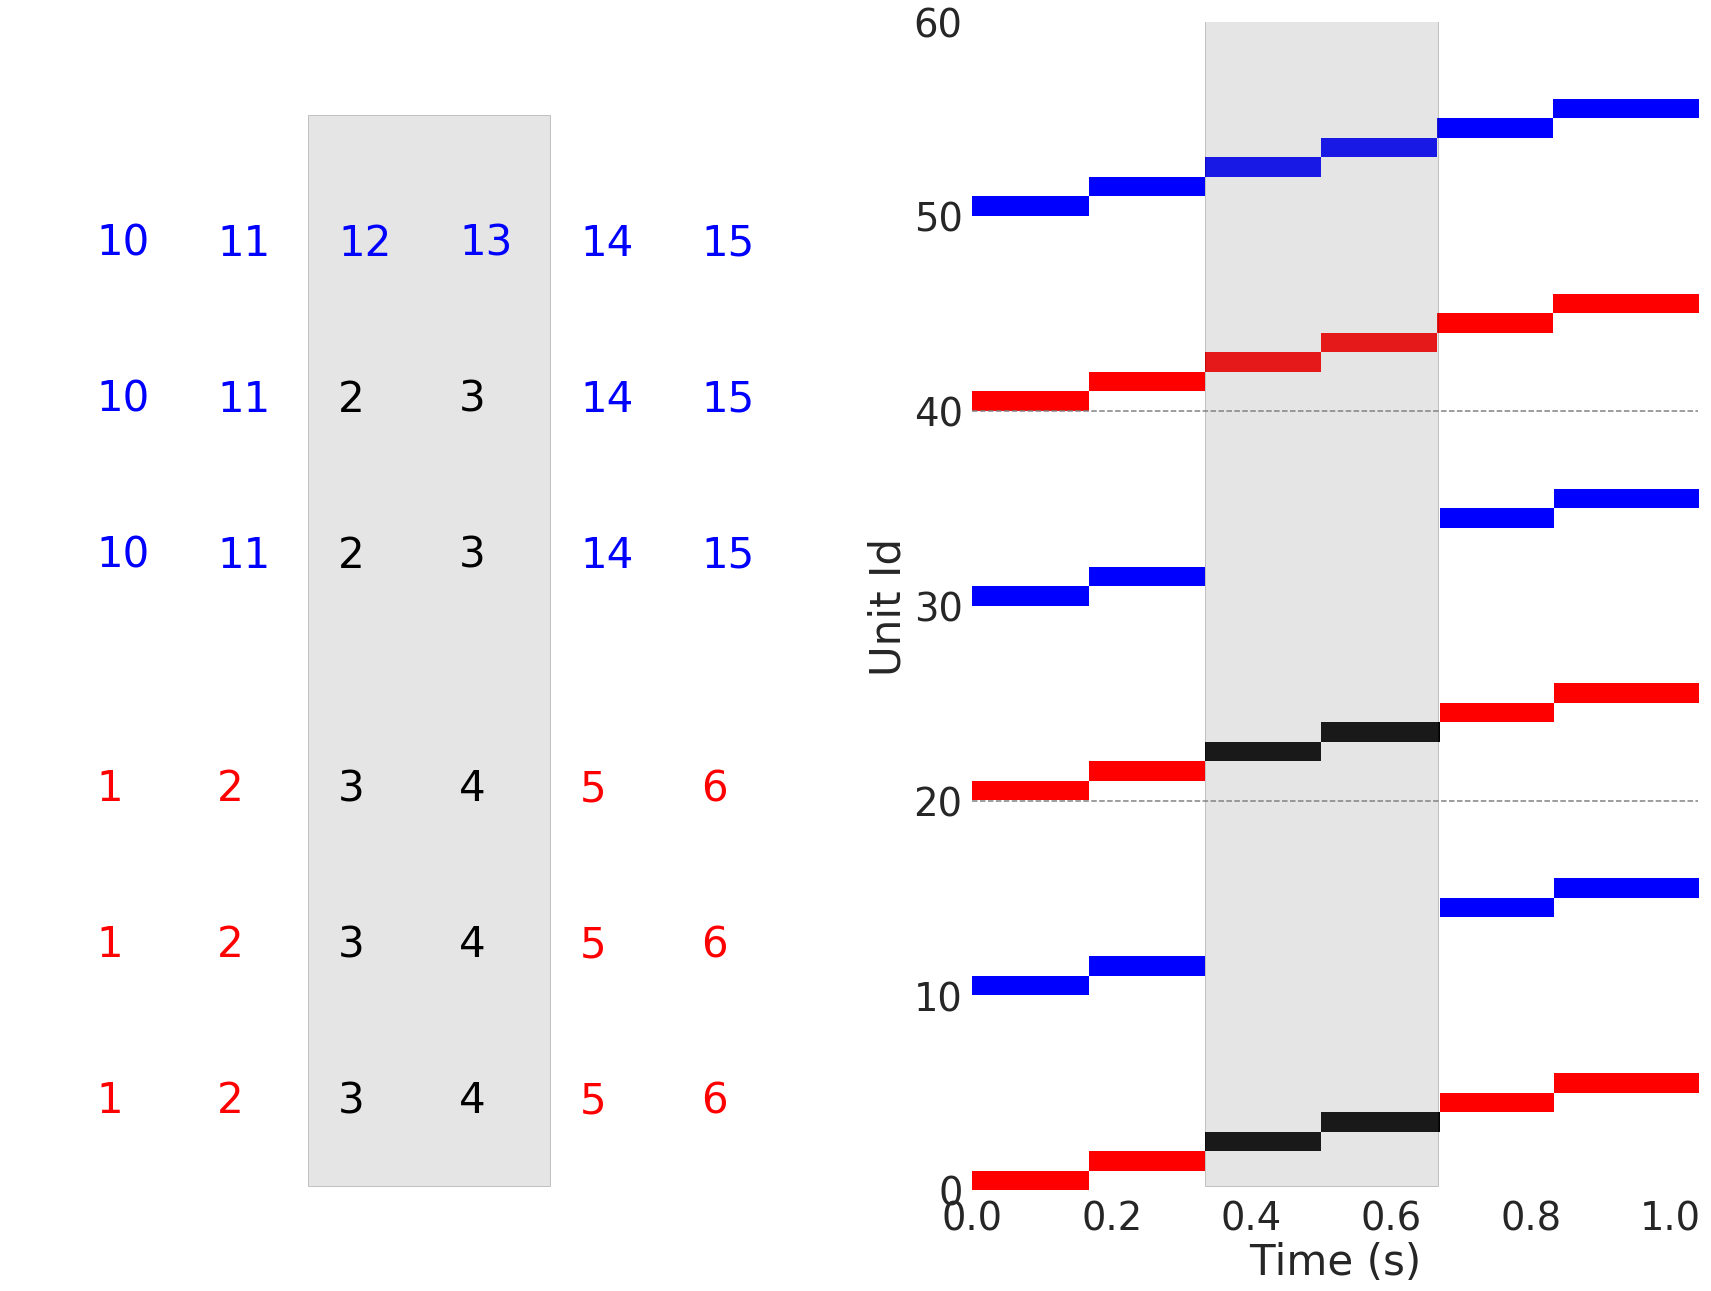

In [13]:
rect = plt.Rectangle((2*T_persistence, 0.2), 2*T_persistence, 55,
                     linewidth=1, edgecolor='black',facecolor='gray', alpha=0.2)
rect2 = plt.Rectangle((2*T_persistence, 0.2), 2*T_persistence, minicolumns * hypercolumns, 
                      linewidth=1, edgecolor='black',facecolor='gray', alpha=0.2)

intersection = {2, 3}

save = True
frame_recall = False
sns.set(font_scale=3.5)
sns.set_style("whitegrid", {'axes.grid': False})

factor_scale = 1.6
s1 = int(16 * factor_scale)
s2 = int(12 * factor_scale)

gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(s1, s2))
ax = fig.add_subplot(gs[:, 0])
ax.set_ylim([0, minicolumns * hypercolumns])

start = T_persistence * 0.25
dx = T_persistence
dy = minicolumns * 0.4
y1 = 32
y2 = 4

sequence1 = activity_representation[:patterns_per_sequence]
sequence2 = activity_representation[patterns_per_sequence:]

x = start
for pattern in sequence2:
    for index, unit in enumerate(pattern): 
        if pattern[index] in intersection:
            color = 'black'
        else:
            color = 'blue'
        ax.text(x, y1 + index*dy, str(pattern[index]), color=color)
    x += dx

x = start 
for pattern in sequence1:
    for index, unit in enumerate(pattern):
        if pattern[index] in intersection:
            color = 'black'
        else:
            color = 'red'
        ax.text(x, y2 + index*dy, str(pattern[index] + 1), color=color)
    x += dx

ax.add_patch(rect)
ax.axis('off')
#ax.text(0.3, 25, r'{', rotation=270, fontsize=150)

################
# The sequence recall
###############
ax2 = fig.add_subplot(gs[:, 1])

cmap.set_under(color='red')
cmap.set_over(color='blue')

cmap = matplotlib.cm.binary
extent = [0, manager.T_recall_total, 0, minicolumns * hypercolumns]
ax2.imshow((-1 * o1 + 2 * o2).T, origin='lower', cmap=cmap, aspect='auto', extent=extent, vmin=0.0, vmax=1.0)
ax2.axhline(minicolumns, ls='--', color='gray')
ax2.axhline(2 * minicolumns, ls='--', color='gray')

ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Unit Id')

ax2.add_patch(rect2);

if not frame_recall:
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    
    
fig.tight_layout()
if save:
    directory = '../plot_producers/'
    file_name = 'rep_diagram' 
    format_string = '.svg'
    string_to_save = directory + file_name + format_string
    fig.savefig(string_to_save, frameon=False, dpi=110, bbox_inches='tight', transparent=True)

In [11]:
2 in {2, 3}

True